<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="45%" align="right" border="4">

# Quickstart

This brief first part illustrates---without much explanation---the usage of the DX Analytics library. It models two risk factors, two derivatives instruments and values these in a portfolio context.

In [1]:
import warnings; warnings.simplefilter('ignore')

In [2]:
import dx
import datetime as dt
import pandas as pd
import seaborn as sns; sns.set()

## Risk Factor Models

The first step is to define a **model for the risk-neutral discounting**.

In [3]:
r = dx.constant_short_rate('r', 0.01)

We then define a **market environment** containing the major parameter specifications needed,

In [4]:
me_1 = dx.market_environment('me', dt.datetime(2015, 1, 1))

In [5]:
me_1.add_constant('initial_value', 100.)
  # starting value of simulated processes
me_1.add_constant('volatility', 0.2)
  # volatiltiy factor
me_1.add_constant('final_date', dt.datetime(2016, 6, 30))
  # horizon for simulation
me_1.add_constant('currency', 'EUR')
  # currency of instrument
me_1.add_constant('frequency', 'W')
  # frequency for discretization
me_1.add_constant('paths', 10000)
  # number of paths
me_1.add_curve('discount_curve', r)
  # number of paths

Next, the model object for the **first risk factor**, based on the geometric Brownian motion (Black-Scholes-Merton (1973) model).

In [6]:
gbm_1 = dx.geometric_brownian_motion('gbm_1', me_1)

Some paths visualized.

In [7]:
pdf = pd.DataFrame(gbm_1.get_instrument_values(), index=gbm_1.time_grid)

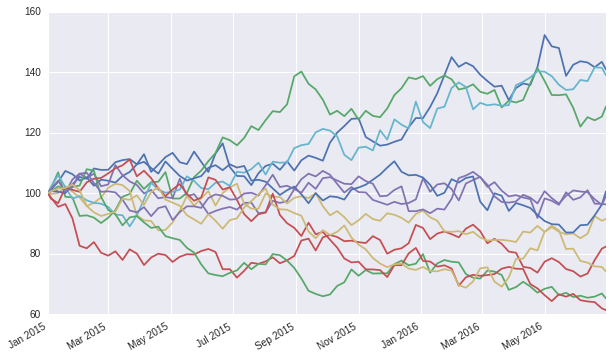

In [8]:
%matplotlib inline
pdf.ix[:, :10].plot(legend=False, figsize=(10, 6))

**Second risk factor** with higher volatility. We overwrite the respective value in the market environment.

In [9]:
me_2 = dx.market_environment('me_2', me_1.pricing_date)
me_2.add_environment(me_1)  # add complete environment
me_2.add_constant('volatility', 0.5)  # overwrite value

In [10]:
gbm_2 = dx.geometric_brownian_motion('gbm_2', me_2)

In [11]:
pdf = pd.DataFrame(gbm_2.get_instrument_values(), index=gbm_2.time_grid)

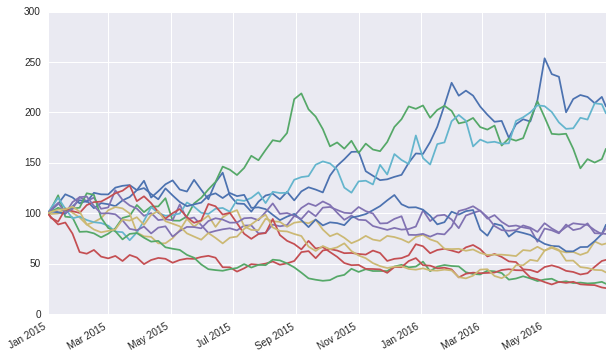

In [12]:
pdf.ix[:, :10].plot(legend=False, figsize=(10, 6))

## Valuation Models

Based on the risk factors, we can then define derivatives models for valuation. To this end, we need to add at least one (the `maturity`), in general two (`maturity` and `strike`), parameters to the market environments.

In [13]:
me_opt = dx.market_environment('me_opt', me_1.pricing_date)
me_opt.add_environment(me_1)
me_opt.add_constant('maturity', dt.datetime(2016, 6, 30))
me_opt.add_constant('strike', 110.)

The first derivative is an **American put option** on the first risk factor `gbm_1`.

In [14]:
am_put = dx.valuation_mcs_american_single(
            name='am_put',
            underlying=gbm_1,
            mar_env=me_opt,
            payoff_func='np.maximum(strike - instrument_values, 0)')

Let us calculate a **Monte Carlo present value estimate** and estimates for the option **Greeks**.

In [15]:
am_put.present_value()

15.019

In [16]:
am_put.delta()

-0.539

In [17]:
am_put.gamma()

-0.0142

In [18]:
am_put.vega()

57.1324

In [19]:
am_put.theta()

-1.5846

In [20]:
am_put.rho()

-74.9269

The second derivative is a **European call option** on the second risk factor `gbm_2`.

In [21]:
eur_call = dx.valuation_mcs_european_single(
            name='eur_call',
            underlying=gbm_2,
            mar_env=me_opt,
            payoff_func='np.maximum(maturity_value - strike, 0)')

Valuation and Greek estimation for this option.

In [22]:
eur_call.present_value()

20.659128

In [23]:
eur_call.delta()

0.8459

In [24]:
eur_call.gamma()

0.0066

In [25]:
eur_call.vega()

48.3195

In [26]:
eur_call.theta()

-8.9143

In [27]:
eur_call.rho()

54.3662

## Excursion: SABR Model 

To illustrate how general the approach of DX Analytics is, let us quickly analyze an option based on a SABR stochastic volatility process. In what follows herafter, the SABR model does not play a role.

We need to define different parameters obviously.

In [28]:
me_3 = dx.market_environment('me_3', me_1.pricing_date)
me_3.add_environment(me_1)  # add complete environment

In [29]:
# interest rate like parmeters
me_3.add_constant('initial_value', 0.05)
  # initial value
me_3.add_constant('alpha', 0.1)
  # initial variance
me_3.add_constant('beta', 0.5)
  # exponent
me_3.add_constant('rho', 0.1)
  # correlation factor
me_3.add_constant('vol_vol', 0.5)
  # volatility of volatility/variance

The model object instantiation.

In [30]:
sabr = dx.sabr_stochastic_volatility('sabr', me_3)

The valuation object instantiation.

In [31]:
me_opt.add_constant('strike', me_3.get_constant('initial_value'))

In [32]:
sabr_call = dx.valuation_mcs_european_single(
            name='sabr_call',
            underlying=sabr,
            mar_env=me_opt,
            payoff_func='np.maximum(maturity_value - strike, 0)')

Some statistics --- same syntax/API even if the model is more complex.

In [33]:
sabr_call.present_value(fixed_seed=True)

0.02586

In [34]:
sabr_call.delta()

0.815

In [35]:
sabr_call.rho()

-0.0385

## Options Portfolio

### Modeling

In a portfolio context, we need to add **information about the model class(es)** to be used to the market environments of the risk factors.

In [36]:
me_1.add_constant('model', 'gbm')
me_2.add_constant('model', 'gbm')

To compose a portfolio consisting of our just defined options, we need to define **derivatives positions**. Note that this step is *independent* from the risk factor model and option model definitions. We only use the market environment data and some additional information needed (e.g. payoff functions).

In [37]:
put = dx.derivatives_position(
            name='put',
            quantity=2,
            underlyings=['gbm_1'],
            mar_env=me_opt,
            otype='American single',
            payoff_func='np.maximum(strike - instrument_values, 0)')

In [38]:
call = dx.derivatives_position(
            name='call',
            quantity=3,
            underlyings=['gbm_2'],
            mar_env=me_opt,
            otype='European single',
            payoff_func='np.maximum(maturity_value - strike, 0)')

Let us define the **relevant market** by 2 Python dictionaries, the correlation between the two risk factors and a valuation environment.

In [39]:
risk_factors = {'gbm_1': me_1, 'gbm_2' : me_2}
correlations = [['gbm_1', 'gbm_2', -0.4]]
positions = {'put' : put, 'call' : call}

In [40]:
val_env = dx.market_environment('general', dt.datetime(2015, 1, 1))
val_env.add_constant('frequency', 'W')
val_env.add_constant('paths', 10000)
val_env.add_constant('starting_date', val_env.pricing_date)
val_env.add_constant('final_date', val_env.pricing_date)
val_env.add_curve('discount_curve', r)

These are used to define the **derivatives portfolio**.

In [41]:
port = dx.derivatives_portfolio(
            name='portfolio',  # name 
            positions=positions,  # derivatives positions
            val_env=val_env,  # valuation environment
            risk_factors=risk_factors, # relevant risk factors
            correlations=correlations, parallel=True)  # correlation between risk factors

### Simulation and Valuation

Now, we can get the **position values for the portfolio** via the `get_values` method.

In [42]:
port.get_values()

Total
pos_value    298.318263
dtype: float64


,position,name,quantity,otype,risk_facts,value,currency,pos_value
0,put,put,2,American single,[gbm_1],0.000000,EUR,0.000000
1,call,call,3,European single,[gbm_2],99.439421,EUR,298.318263


Via the `get_statistics` methods delta and vega values are provided as well.

In [43]:
port.get_statistics()

Totals
pos_value    298.318263
pos_delta      2.984700
pos_vega      -6.193200
dtype: float64


,position,name,quantity,otype,risk_facts,value,currency,pos_value,pos_delta,pos_vega
0,put,put,2,American single,[gbm_1],0.000000,EUR,0.000000,0.0000,0.0000
1,call,call,3,European single,[gbm_2],99.439421,EUR,298.318263,2.9847,-6.1932


Much more complex scenarios are possible with DX Analytics

### Risk Reports

Having modeled the derivatives portfolio, **risk reports** are only two method calls away.

In [44]:
deltas, benchvalue = port.get_port_risk(Greek='Delta')


gbm_1
0.8 0.9 1.0 1.1 1.2 
gbm_2
0.8 0.9 1.0 1.1 1.2 




In [45]:
dx.risk_report(deltas)


gbm_1_Delta
           0.8     0.9     1.0     1.1     1.2
factor   80.00   90.00  100.00  110.00  120.00
value   298.32  298.32  298.32  298.32  298.32

gbm_2_Delta
           0.8     0.9     1.0     1.1     1.2
factor   80.00   90.00  100.00  110.00  120.00
value   238.63  268.47  298.32  328.16  358.01


In [46]:
dx.risk_report(deltas.ix[:, :, 'value'] - benchvalue)


gbm_1_Delta
0.8    0
0.9    0
1.0    0
1.1    0
1.2    0
Name: gbm_1_Delta, dtype: float64

gbm_2_Delta
0.8   -59.69
0.9   -29.85
1.0     0.00
1.1    29.85
1.2    59.69
Name: gbm_2_Delta, dtype: float64


In [47]:
vegas, benchvalue = port.get_port_risk(Greek='Vega', step=0.05)


gbm_1
0.8 0.85 0.9 0.95 1.0 1.05 1.1 1.15 1.2 
gbm_2
0.8 0.85 0.9 0.95 1.0 1.05 1.1 1.15 1.2 




In [48]:
dx.risk_report(vegas)


gbm_1_Vega
          0.80    0.85    0.90    0.95    1.00    1.05    1.10    1.15    1.20
factor    0.16    0.17    0.18    0.19    0.20    0.21    0.22    0.23    0.24
value   298.32  298.32  298.32  298.32  298.32  298.32  298.32  298.32  298.32

gbm_2_Vega
          0.80    0.85    0.90    0.95    1.00    1.05    1.10    1.15    1.20
factor    0.40    0.43    0.45    0.48    0.50    0.53    0.55    0.58    0.60
value   298.87  298.74  298.61  298.47  298.32  298.16  298.00  297.82  297.64


In [49]:
dx.risk_report(vegas.ix[:, :, 'value'] - benchvalue)


gbm_1_Vega
0.80    0
0.85    0
0.90    0
0.95    0
1.00    0
1.05    0
1.10    0
1.15    0
1.20    0
Name: gbm_1_Vega, dtype: float64

gbm_2_Vega
0.80    0.55
0.85    0.43
0.90    0.29
0.95    0.15
1.00    0.00
1.05   -0.16
1.10   -0.32
1.15   -0.49
1.20   -0.67
Name: gbm_2_Vega, dtype: float64


**Copyright, License & Disclaimer**

&copy; Dr. Yves J. Hilpisch | The Python Quants GmbH

DX Analytics (the "dx library") is licensed under the GNU Affero General Public License
version 3 or later (see [http://www.gnu.org/licenses/](http://www.gnu.org/licenses/)).

DX Analytics comes with no representations
or warranties, to the extent permitted by applicable law.


<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

[http://tpq.io](http://tpq.io) | [team@tpq.io](mailto:team@tpq.io) | [http://twitter.com/dyjh](http://twitter.com/dyjh)

**Quant Platform** |
[http://quant-platform.com](http://quant-platform.com)

**Derivatives Analytics with Python (Wiley Finance)** |
[http://derivatives-analytics-with-python.com](http://derivatives-analytics-with-python.com)

**Python for Finance (O'Reilly)** |
[http://python-for-finance.com](http://python-for-finance.com)